### **Import Libraries**

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supress warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Scikit-learn untuk preprocessing dan modeling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Model boosting terbaru
from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from ngboost.scores import LogScore  
from snapml import BoostingMachineClassifier  

from lib.utils import gcForest

from pytorch_tabnet.tab_model import TabNetClassifier

# Hyperparameter tuning
import optuna
from skopt import BayesSearchCV 

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)


### **Load & Split Data**

In [2]:
df = pd.read_csv('data/preprocessed_data.csv')

cols_to_keep = [
    "age", 
    "height", 
    "weight", 
    "systolic", 
    "diastolic", 
    "cholesterol", 
    "gluc", 
    "gender", 
    "smoke", 
    "alco", 
    "active", 
    "cardio"
]

df = df[cols_to_keep]

print('Sample Data')
display(df.head())

Sample Data


,age,height,weight,systolic,diastolic,cholesterol,gluc,gender,smoke,alco,active,cardio
0,50,168,62.0,110,80,0,0,1,0,0,1,0
1,55,156,85.0,140,90,2,0,0,0,0,1,1
2,51,165,64.0,130,70,2,0,0,0,0,0,1
3,48,169,82.0,150,100,0,0,1,0,0,1,1
4,60,151,67.0,120,80,1,1,0,0,0,0,0


In [3]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

In [4]:
label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

### **Scaling Data**

In [5]:
standard_features = ['age', 'height', 'weight','systolic', 'diastolic']
categorical_features = [ 'cholesterol', 'gluc','gender', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)

In [6]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

,age,height,weight,systolic,diastolic,cholesterol,gluc,gender,smoke,alco,active
0,-0.417980,0.455073,-0.917504,-1.148837,-0.240613,0.0,0.0,1.0,0.0,0.0,1.0
1,0.322373,-1.073480,0.702839,0.899939,1.039156,2.0,0.0,0.0,0.0,0.0,1.0
2,-0.269909,0.072935,-0.776604,0.217014,-1.520382,2.0,0.0,0.0,0.0,0.0,0.0
3,-0.714121,0.582452,0.491490,1.582864,2.318925,0.0,0.0,1.0,0.0,0.0,1.0
4,1.062727,-1.710377,-0.565255,-0.465911,-0.240613,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
59992,0.618515,0.072935,0.350591,1.582864,-0.240613,0.0,0.0,0.0,0.0,0.0,1.0
59993,-0.121839,0.455073,0.068792,-0.465911,-0.240613,0.0,0.0,1.0,1.0,0.0,1.0
59994,1.210798,-0.818721,3.591277,0.899939,1.039156,1.0,1.0,0.0,0.0,0.0,1.0
59995,1.210798,-0.181824,-0.213007,0.558476,-0.240613,0.0,1.0,0.0,0.0,0.0,0.0


### **Train, Val, Test**

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42, stratify=y)  # Train 70%
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%

In [8]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_val_np = np.array(x_val)
y_val_np = np.array(y_val)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

### **Base Model**

In [9]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    """
    Generic evaluation function that adapts its training and prediction process
    based on the model type.
    
    If the model has a 'cascade_forest' method (e.g., gcForest), it will use that
    for training and prediction; otherwise, it assumes the model follows the standard
    interface (fit, predict, predict_proba).
    """
    # Determine the branch based on model type
    if hasattr(model, 'cascade_forest'):
        print("Using cascade_forest branch for training and prediction...")
        # Train the model with cascade_forest (when y is provided, training occurs)
        model.cascade_forest(x_train, y_train)
        # Define lambda functions for prediction and probability prediction
        predict_func = lambda x: np.argmax(np.mean(model.cascade_forest(x), axis=0), axis=1)
        predict_proba_func = lambda x: np.mean(model.cascade_forest(x), axis=0)
    else:
        print("Using standard branch (fit/predict/predict_proba)...")
        model.fit(x_train, y_train)
        predict_func = lambda x: model.predict(x)
        predict_proba_func = lambda x: model.predict_proba(x)
    
    # Predictions on test data
    y_pred_test = predict_func(x_test)
    y_proba_test = predict_proba_func(x_test)
    
    # For binary classification, use the probability for the positive class (index 1)
    if y_proba_test.shape[1] > 1:
        y_probs_test = y_proba_test[:, 1]
    else:
        y_probs_test = y_proba_test[:, 0]
    
    # Predictions on training data (for overfitting check)
    y_pred_train = predict_func(x_train)
    y_proba_train = predict_proba_func(x_train)
    if y_proba_train.shape[1] > 1:
        y_probs_train = y_proba_train[:, 1]
    else:
        y_probs_train = y_proba_train[:, 0]
    
    # Calculate evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred_test) * 100
    test_auc = roc_auc_score(y_test, y_probs_test)
    test_report = classification_report(y_test, y_pred_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train) * 100
    train_auc = roc_auc_score(y_train, y_probs_train)
    
    # Print evaluation results
    print(f"\nClassification Report for {model_name}:\n{test_report}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}%")
    print(f"{model_name} Test AUC: {test_auc:.4f}")
    print(f"\n{model_name} Training Accuracy: {train_accuracy:.2f}%")
    print(f"{model_name} Training AUC: {train_auc:.4f}")
    
    print("\nOverfitting Check:")
    if train_accuracy > test_accuracy + 5 or train_auc > test_auc + 0.05:
        print("The model might be overfitting.")
    else:
        print("No significant signs of overfitting.")
    
    # Plot Confusion Matrix and ROC Curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm = confusion_matrix(y_test, y_pred_test)
    # If a global variable 'label_mapping' exists, use it for display labels
    display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=axes[0], cmap='viridis', colorbar=False)
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    
    fpr, tpr, _ = roc_curve(y_test, y_probs_test)
    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
    axes[1].set_title(f"{model_name} - ROC Curve")
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

##### `Logistic Regression`

Using standard branch (fit/predict/predict_proba)...



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3234
           1       0.76      0.69      0.72      2766

    accuracy                           0.75      6000
   macro avg       0.76      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000

Logistic Regression Test Accuracy: 75.47%
Logistic Regression Test AUC: 0.8268

Logistic Regression Training Accuracy: 75.69%
Logistic Regression Training AUC: 0.8253

Overfitting Check:
No significant signs of overfitting.


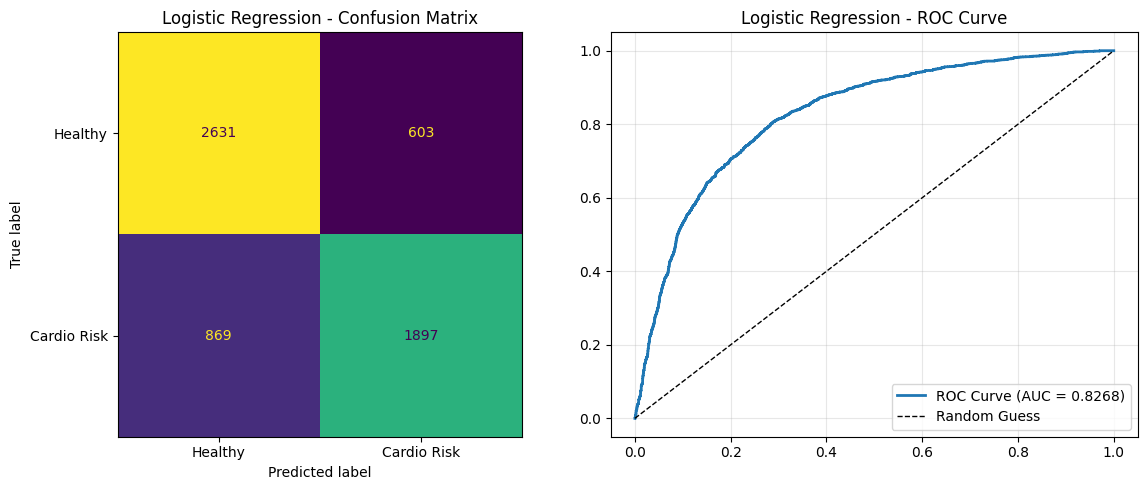

In [10]:
logreg_model = LogisticRegression()

evaluate_model(logreg_model, x_train_np, y_train_np, x_test_np, y_test_np, "Logistic Regression")

##### `Random Forest`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3234
           1       0.72      0.73      0.72      2766

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000

Random Forest Test Accuracy: 74.27%
Random Forest Test AUC: 0.8205

Random Forest Training Accuracy: 99.03%
Random Forest Training AUC: 0.9995

Overfitting Check:
The model might be overfitting.


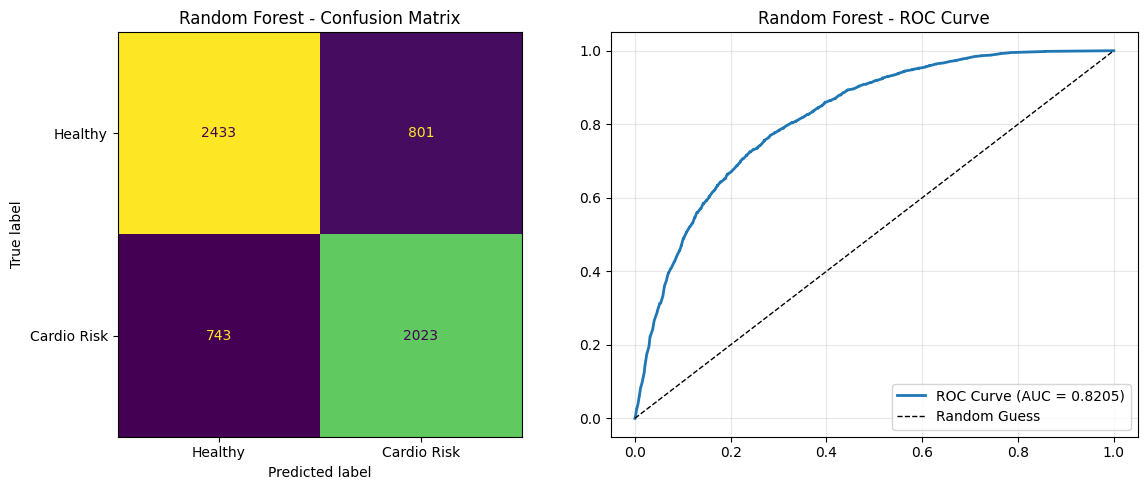

In [11]:
rf_model = RandomForestClassifier()

evaluate_model(rf_model, x_train_np, y_train_np, x_test_np, y_test_np, "Random Forest")

##### `Decision Tree`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      3234
           1       0.65      0.65      0.65      2766

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000

Decision Tree Test Accuracy: 67.35%
Decision Tree Test AUC: 0.6740

Decision Tree Training Accuracy: 99.03%
Decision Tree Training AUC: 0.9998

Overfitting Check:
The model might be overfitting.


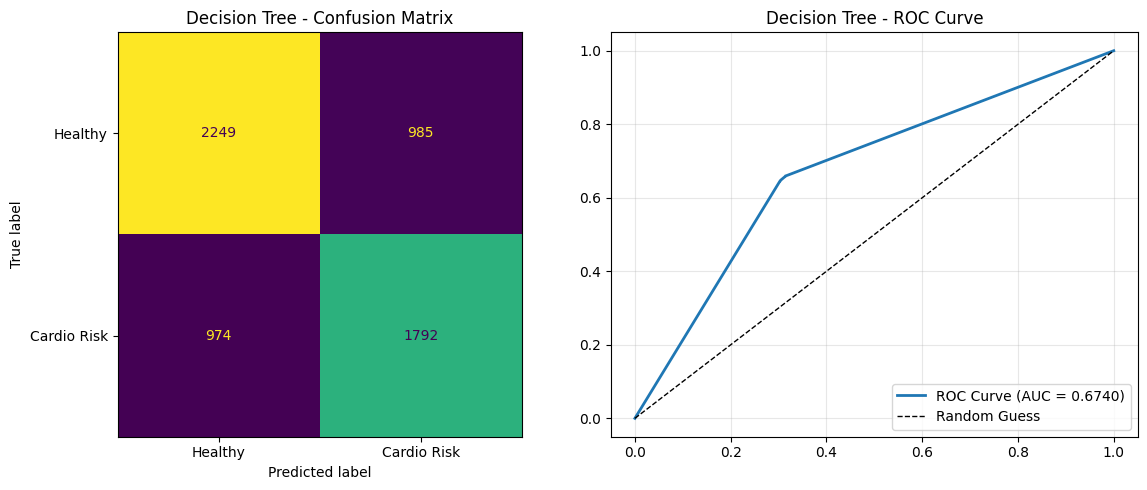

In [12]:
dt_model = DecisionTreeClassifier()

evaluate_model(dt_model, x_train_np, y_train_np, x_test_np, y_test_np, "Decision Tree")

##### `SVM`

Using standard branch (fit/predict/predict_proba)...



Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3234
           1       0.76      0.72      0.74      2766

    accuracy                           0.77      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.77      0.77      0.76      6000

SVM Test Accuracy: 76.55%
SVM Test AUC: 0.8294

SVM Training Accuracy: 76.89%
SVM Training AUC: 0.8425

Overfitting Check:
No significant signs of overfitting.


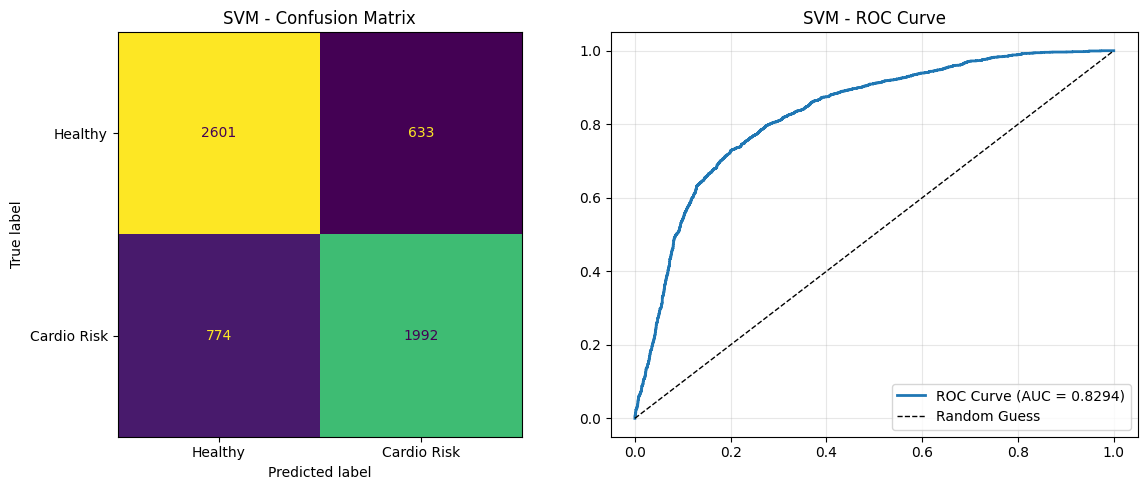

In [13]:
svm_model = SVC(probability=True)

evaluate_model(svm_model, x_train_np, y_train_np, x_test_np, y_test_np, "SVM")

##### `Naive Bayes`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3234
           1       0.76      0.66      0.71      2766

    accuracy                           0.75      6000
   macro avg       0.75      0.74      0.74      6000
weighted avg       0.75      0.75      0.74      6000

Naive Bayes Test Accuracy: 74.70%
Naive Bayes Test AUC: 0.8170

Naive Bayes Training Accuracy: 74.67%
Naive Bayes Training AUC: 0.8162

Overfitting Check:
No significant signs of overfitting.


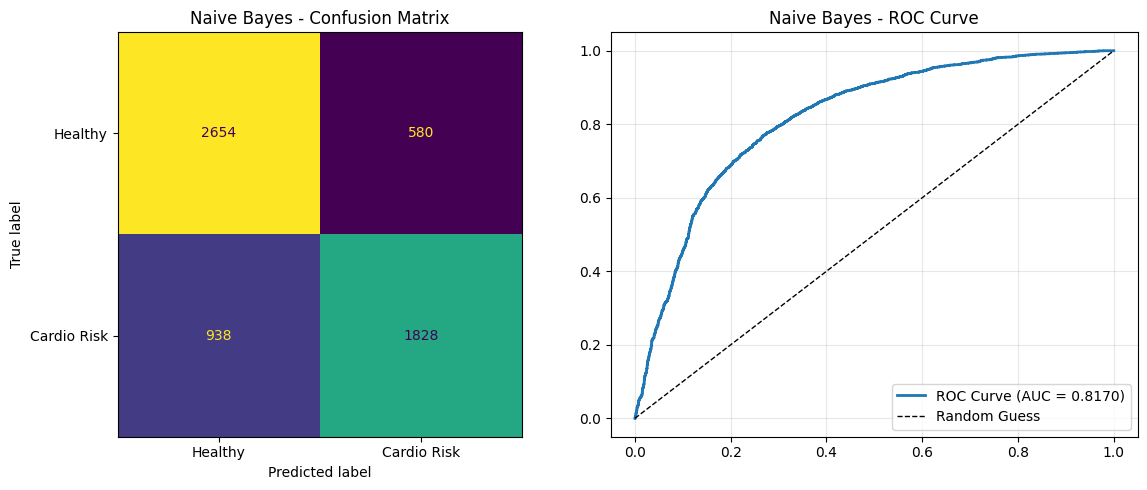

In [14]:
nb_model = GaussianNB()

evaluate_model(nb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Naive Bayes")

##### `KNN`

Using standard branch (fit/predict/predict_proba)...

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3234
           1       0.70      0.72      0.71      2766

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000

KNN Test Accuracy: 73.00%
KNN Test AUC: 0.7963

KNN Training Accuracy: 81.27%
KNN Training AUC: 0.9001

Overfitting Check:
The model might be overfitting.


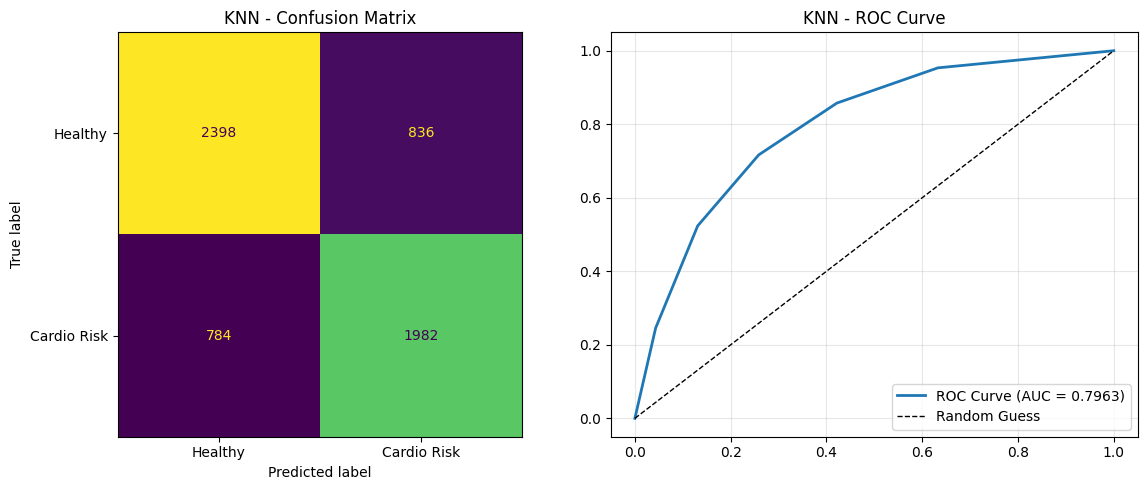

In [15]:
knn_model = KNeighborsClassifier()

evaluate_model(knn_model, x_train_np, y_train_np, x_test_np, y_test_np, "KNN")

##### `XGBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      3234
           1       0.74      0.73      0.74      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000

XGBoost Test Accuracy: 76.00%
XGBoost Test AUC: 0.8377

XGBoost Training Accuracy: 79.92%
XGBoost Training AUC: 0.8870

Overfitting Check:
No significant signs of overfitting.


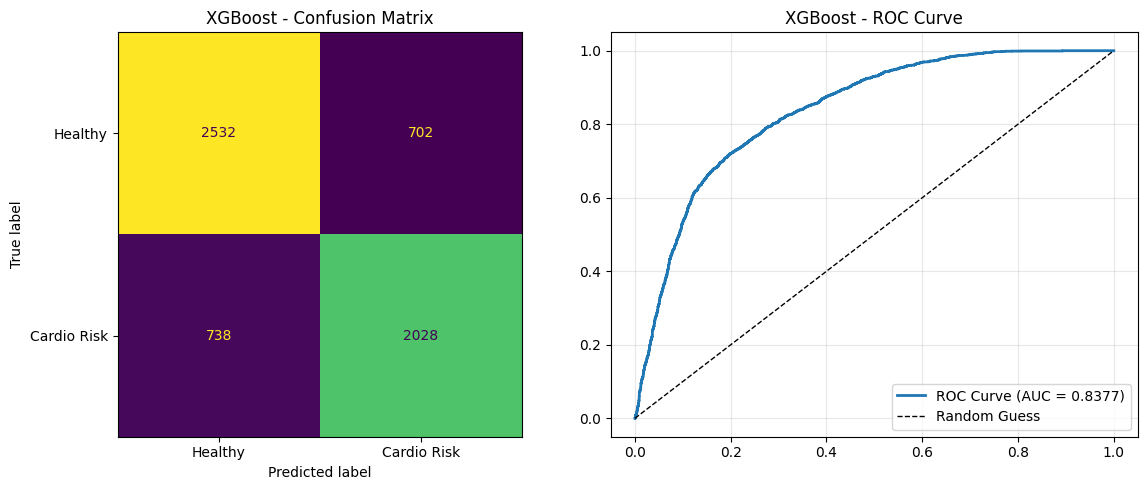

In [16]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

evaluate_model(xgb_model, x_train_np, y_train_np, x_test_np, y_test_np, "XGBoost")

Best trial:
{'n_estimators': 400, 'learning_rate': 0.05005860238313247, 'max_depth': 9, 'gamma': 0.5, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.5, 'reg_alpha': 6.464666823727045, 'reg_lambda': 7.4394957128407375}
Using standard branch (fit/predict/predict_proba)...

Classification Report for XGBoost Optuna Tuning:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3234
           1       0.75      0.74      0.74      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000

XGBoost Optuna Tuning Test Accuracy: 76.33%
XGBoost Optuna Tuning Test AUC: 0.8431

XGBoost Optuna Tuning Training Accuracy: 77.82%
XGBoost Optuna Tuning Training AUC: 0.8600

Overfitting Check:
No significant signs of overfitting.


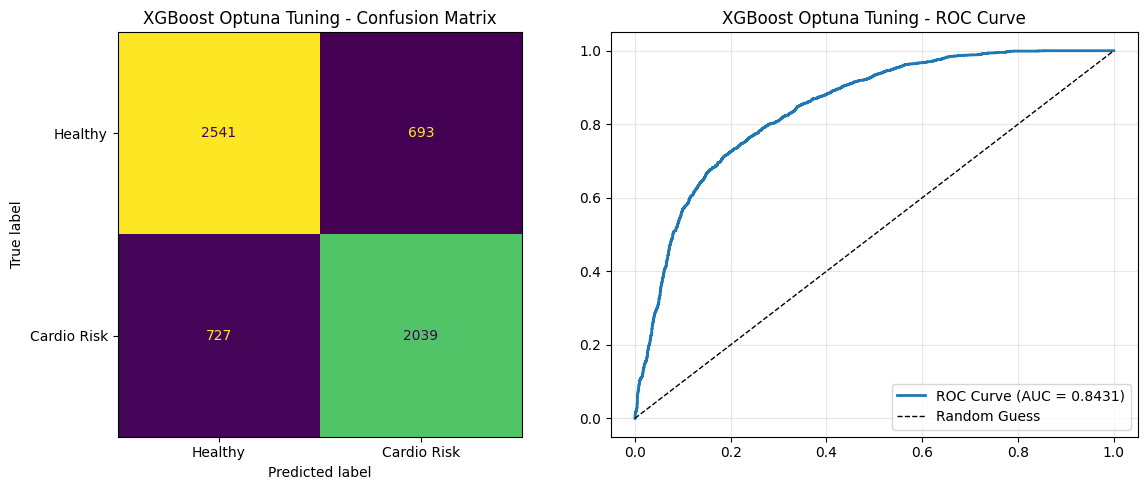

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'eval_metric': 'logloss',
    }

    xgb_model = XGBClassifier(**param)

    # Menggunakan 3-fold CV agar proses lebih cepat
    scores = cross_val_score(xgb_model, x_train_np, y_train_np, cv=3, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
# Mengurangi jumlah trial menjadi 20
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial.params)

best_params = study.best_trial.params
best_model = XGBClassifier(**best_params)
best_model.fit(x_train_np, y_train_np)

# Evaluasi
evaluate_model(best_model, x_train_np, y_train_np, x_test_np, y_test_np, "XGBoost Optuna Tuning")

##### `Light GBM`

Using standard branch (fit/predict/predict_proba)...

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      3234
           1       0.75      0.74      0.75      2766

    accuracy                           0.77      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.77      0.77      0.77      6000

LightGBM Test Accuracy: 76.82%
LightGBM Test AUC: 0.8441

LightGBM Training Accuracy: 77.93%
LightGBM Training AUC: 0.8656

Overfitting Check:
No significant signs of overfitting.


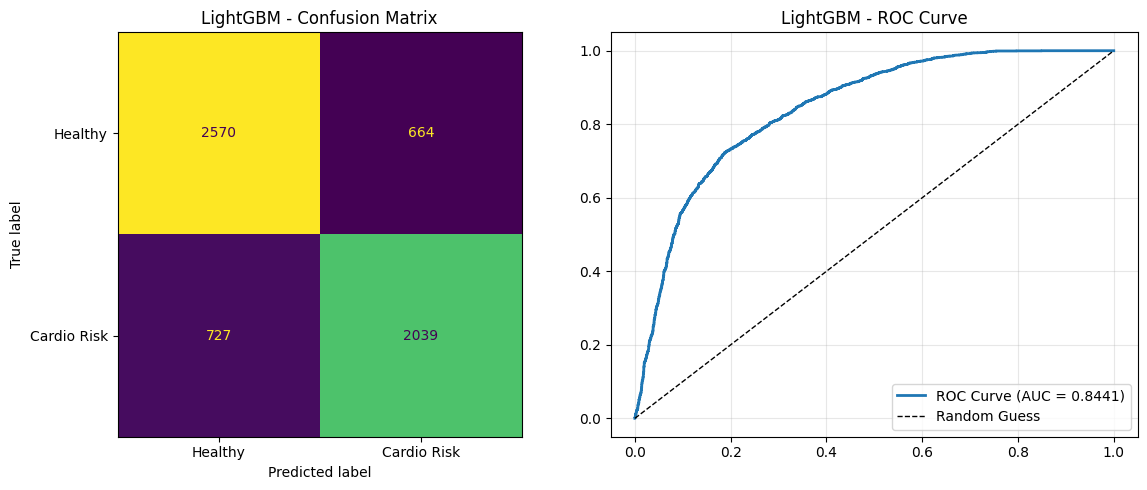

In [17]:
lgbm_model = LGBMClassifier(verbose=-1)

evaluate_model(lgbm_model, x_train_np, y_train_np, x_test_np, y_test_np, "LightGBM")

##### `Cat Boost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3234
           1       0.75      0.74      0.75      2766

    accuracy                           0.77      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.77      0.77      0.77      6000

CatBoost Test Accuracy: 76.68%
CatBoost Test AUC: 0.8421

CatBoost Training Accuracy: 79.03%
CatBoost Training AUC: 0.8758

Overfitting Check:
No significant signs of overfitting.


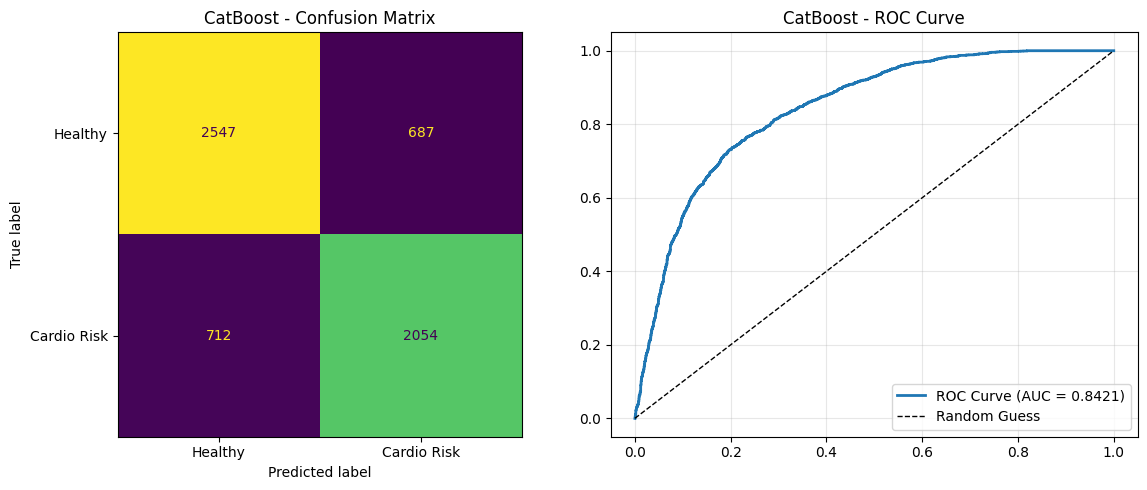

In [18]:
cat_model = CatBoostClassifier(verbose=False)


evaluate_model(cat_model, x_train_np, y_train_np, x_test_np, y_test_np, "CatBoost")

#### `SnapBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for SnapBoost:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3234
           1       0.76      0.72      0.74      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000

SnapBoost Test Accuracy: 76.40%
SnapBoost Test AUC: 0.8400

SnapBoost Training Accuracy: 76.82%
SnapBoost Training AUC: 0.8490

Overfitting Check:
No significant signs of overfitting.


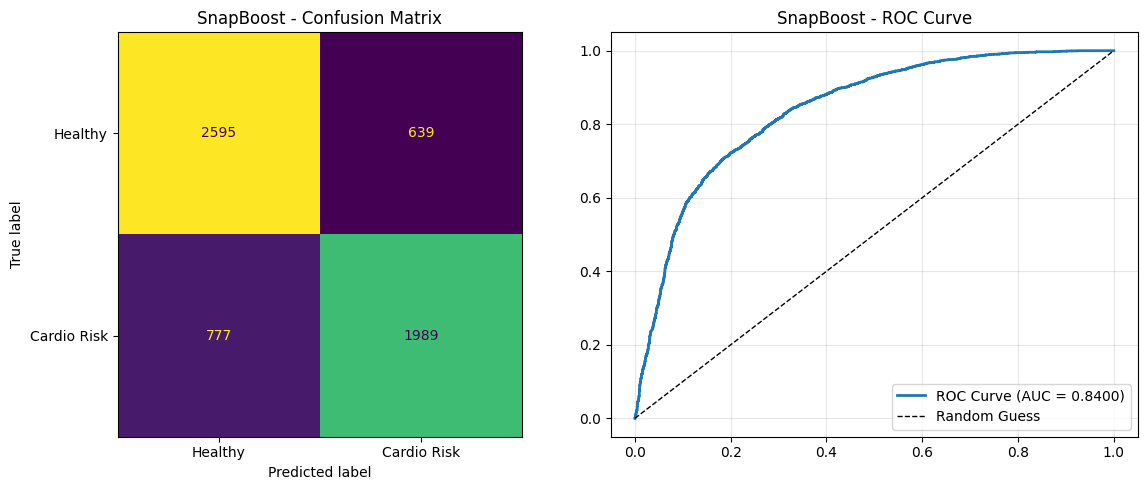

In [19]:
snb_model = BoostingMachineClassifier()

evaluate_model(snb_model, x_train_np, y_train_np, x_test_np, y_test_np, "SnapBoost")

##### `Explainable Boosting Machine (EBM)`

Using standard branch (fit/predict/predict_proba)...



Classification Report for EBM:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3234
           1       0.75      0.72      0.73      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.75      0.76      6000
weighted avg       0.76      0.76      0.76      6000

EBM Test Accuracy: 75.75%
EBM Test AUC: 0.8363

EBM Training Accuracy: 76.35%
EBM Training AUC: 0.8396

Overfitting Check:
No significant signs of overfitting.


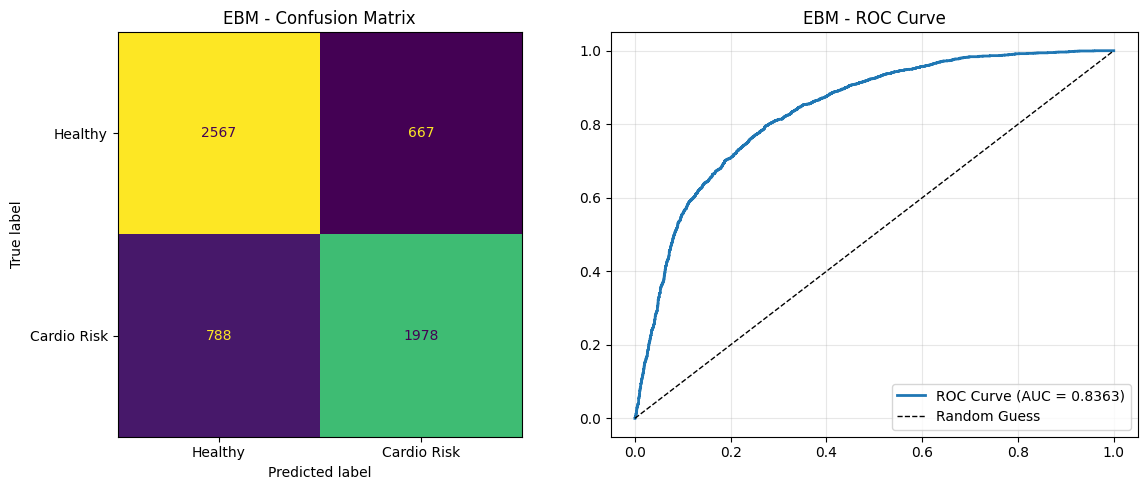

In [20]:
ebm_model = ExplainableBoostingClassifier()

evaluate_model(ebm_model, x_train_np, y_train_np, x_test_np, y_test_np, "EBM")

##### `NGBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for NGBoost:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3234
           1       0.76      0.70      0.73      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.75      0.76      6000
weighted avg       0.76      0.76      0.76      6000

NGBoost Test Accuracy: 75.85%
NGBoost Test AUC: 0.8370

NGBoost Training Accuracy: 76.17%
NGBoost Training AUC: 0.8395

Overfitting Check:
No significant signs of overfitting.


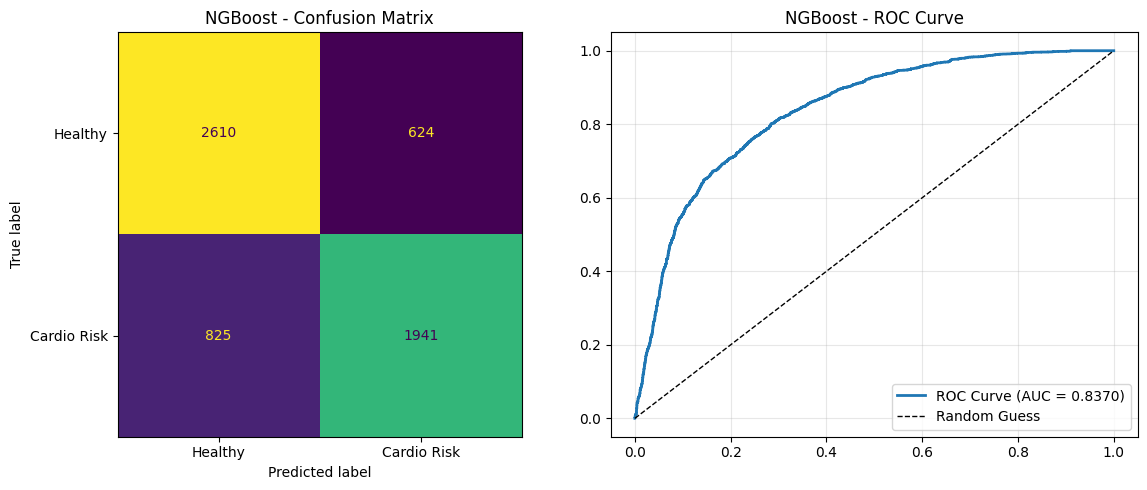

In [21]:
ngb_model = NGBClassifier(Dist=Bernoulli, verbose=False)

evaluate_model(ngb_model, x_train_np, y_train_np, x_test_np, y_test_np, "NGBoost")

##### `AdaBoost`

Using standard branch (fit/predict/predict_proba)...



Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      3234
           1       0.76      0.67      0.72      2766

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000

AdaBoost Test Accuracy: 75.20%
AdaBoost Test AUC: 0.8290

AdaBoost Training Accuracy: 75.41%
AdaBoost Training AUC: 0.8288

Overfitting Check:
No significant signs of overfitting.


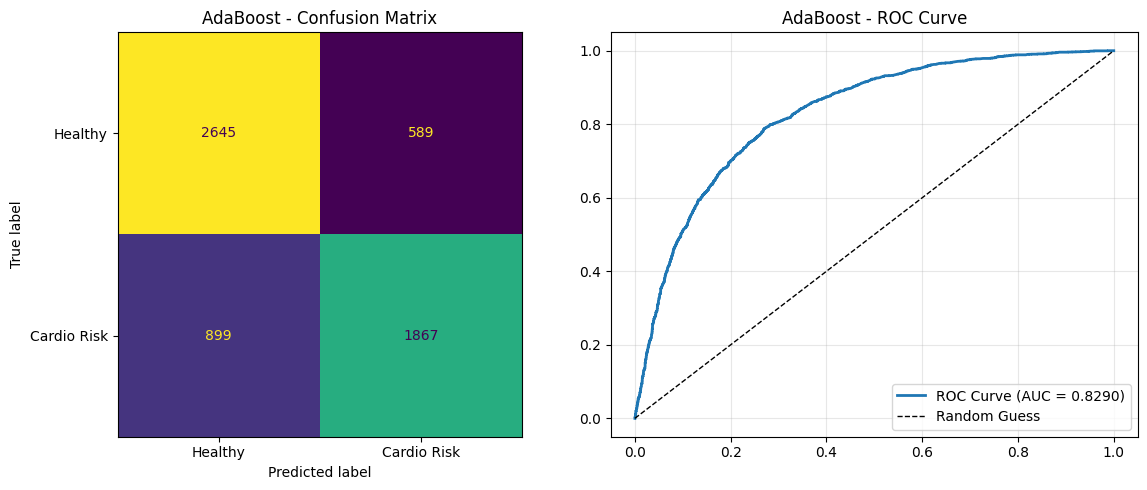

In [22]:
adb_model = AdaBoostClassifier(random_state=42)

evaluate_model(adb_model, x_train_np, y_train_np, x_test_np, y_test_np, "AdaBoost")

##### `GradientBoosting`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      3234
           1       0.75      0.72      0.73      2766

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000

Gradient Boosting Test Accuracy: 76.02%
Gradient Boosting Test AUC: 0.8392

Gradient Boosting Training Accuracy: 76.60%
Gradient Boosting Training AUC: 0.8440

Overfitting Check:
No significant signs of overfitting.


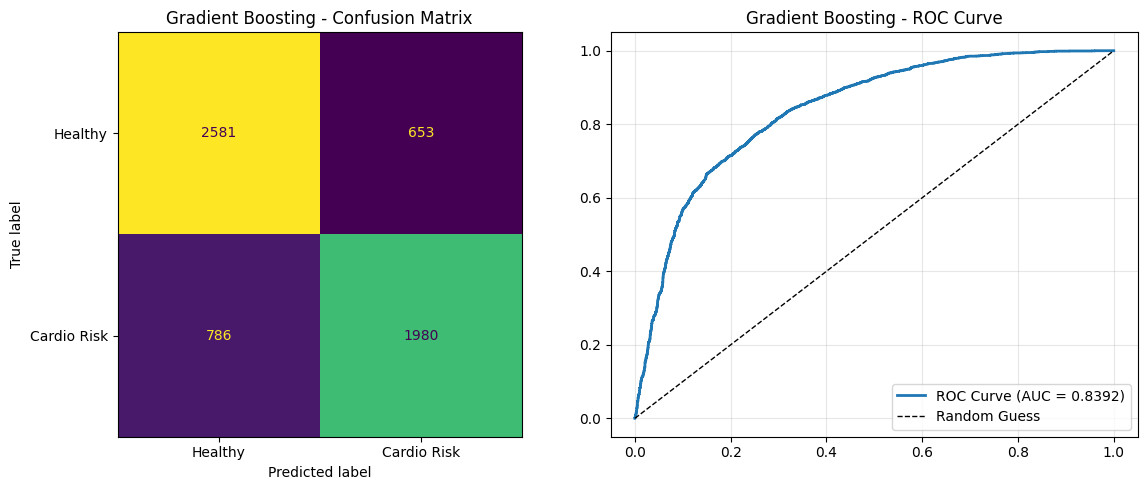

In [23]:
grb_model =  GradientBoostingClassifier(random_state=42)

evaluate_model(grb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Gradient Boosting")

##### `Hist GradientBoosting`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      3234
           1       0.75      0.74      0.74      2766

    accuracy                           0.77      6000
   macro avg       0.77      0.76      0.76      6000
weighted avg       0.77      0.77      0.77      6000

Hist Gradient Boosting Test Accuracy: 76.68%
Hist Gradient Boosting Test AUC: 0.8447

Hist Gradient Boosting Training Accuracy: 77.58%
Hist Gradient Boosting Training AUC: 0.8602

Overfitting Check:
No significant signs of overfitting.


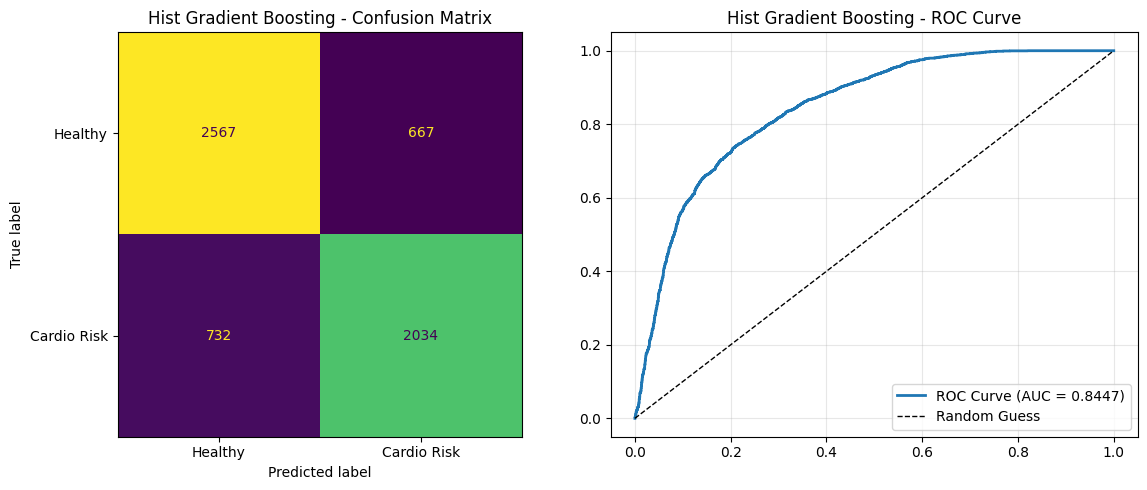

In [24]:
hgrb_model =  HistGradientBoostingClassifier(random_state=42)

evaluate_model(hgrb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Hist Gradient Boosting")

#### `Cascaded Random Forest`

Using cascade_forest branch for training and prediction...
Adding/Training Layer, n_layer=1


Layer validation accuracy = 0.7592857142857142
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.7628571428571429
Adding/Training Layer, n_layer=3
Layer validation accuracy = 0.7703571428571429
Adding/Training Layer, n_layer=4
Layer validation accuracy = 0.7697619047619048

Classification Report for Cascaded Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3234
           1       0.76      0.73      0.74      2766

    accuracy                           0.77      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.77      0.77      0.76      6000

Cascaded Random Forest Test Accuracy: 76.53%
Cascaded Random Forest Test AUC: 0.8361

Cascaded Random Forest Training Accuracy: 76.44%
Cascaded Random Forest Training AUC: 0.8412

Overfitting Check:
No significant signs of overfitting.


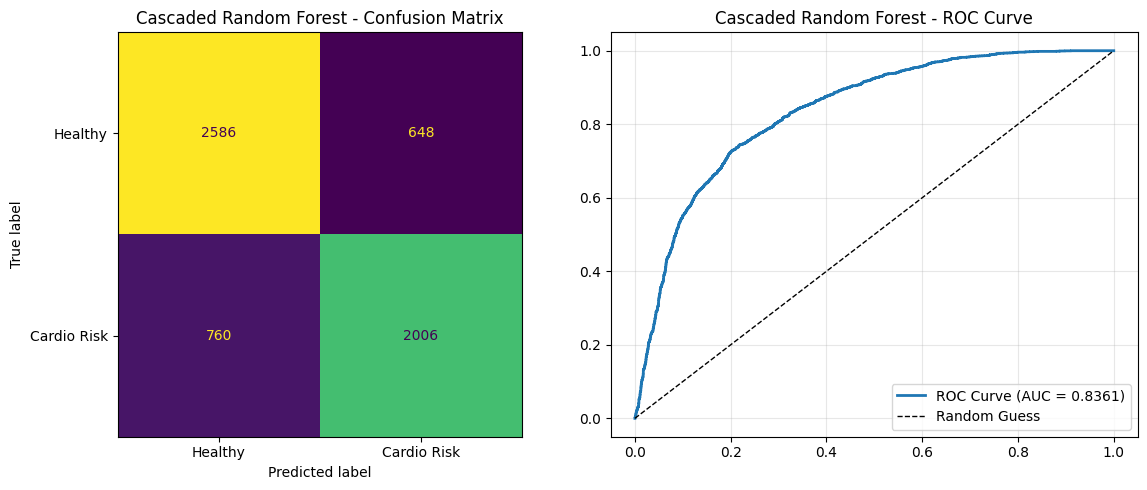

In [25]:
gcf_model = gcForest(n_cascadeRF=2,n_cascadeRFtree=500) #Default values tolerance =0.0 ,n_cascadeRFtree=101

evaluate_model(gcf_model, x_train_np, y_train_np, x_test_np, y_test_np, "Cascaded Random Forest")

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 2. Membangun Model Neural Network ---
# Kita akan membuat model dengan beberapa lapisan Dense dan Dropout untuk mencegah overfitting.
model = Sequential([
    Dense(32, input_dim=x_train_np.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Aktivasi sigmoid untuk klasifikasi biner
])

# Kompilasi model dengan optimizer Adam dan loss binary_crossentropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Gunakan EarlyStopping untuk menghentikan training saat validasi loss tidak membaik selama 10 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- 3. Melatih Model ---
history = model.fit(
    x_train_np, y_train_np,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- 4. Evaluasi Model ---
loss, accuracy = model.evaluate(x_test_np, y_test_np, verbose=0)
print("\nTest Loss: {:.4f}".format(loss))
print("Test Accuracy: {:.4f}".format(accuracy))

# Prediksi untuk data uji
y_pred = model.predict(x_test_np)
# Konversi probabilitas ke kelas (0 atau 1) dengan threshold 0.5
y_pred_class = (y_pred > 0.5).astype(int)

# Tampilkan laporan klasifikasi dan confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_class))

Epoch 1/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.7183 - loss: 0.5723 - val_accuracy: 0.7598 - val_loss: 0.5018
Epoch 2/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.7567 - loss: 0.5138 - val_accuracy: 0.7619 - val_loss: 0.4975
Epoch 3/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.7549 - loss: 0.5129 - val_accuracy: 0.7612 - val_loss: 0.4942
Epoch 4/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.7574 - loss: 0.5064 - val_accuracy: 0.7618 - val_loss: 0.4923
Epoch 5/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.7577 - loss: 0.5023 - val_accuracy: 0.7650 - val_loss: 0.4916
Epoch 6/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.7595 - loss: 0.5000 - val_accuracy: 0.7645 - val_loss: 0.4891
Epoch 7/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.7630 - loss: 0.4948 - val_accuracy: 0.7652 - val_loss: 0.4881
Epoch 8/100
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 

#### `TabNet`

Using standard branch (fit/predict/predict_proba)...
epoch 0  | loss: 0.57343 |  0:00:01s
epoch 1  | loss: 0.52683 |  0:00:02s
epoch 2  | loss: 0.51502 |  0:00:03s
epoch 3  | loss: 0.50891 |  0:00:04s
epoch 4  | loss: 0.50265 |  0:00:05s
epoch 5  | loss: 0.49755 |  0:00:06s
epoch 6  | loss: 0.49597 |  0:00:07s
epoch 7  | loss: 0.49319 |  0:00:08s
epoch 8  | loss: 0.49183 |  0:00:09s
epoch 9  | loss: 0.49046 |  0:00:10s
epoch 10 | loss: 0.48889 |  0:00:11s
epoch 11 | loss: 0.49043 |  0:00:13s
epoch 12 | loss: 0.4884  |  0:00:14s
epoch 13 | loss: 0.48749 |  0:00:15s
epoch 14 | loss: 0.48541 |  0:00:16s
epoch 15 | loss: 0.48529 |  0:00:17s
epoch 16 | loss: 0.48705 |  0:00:18s
epoch 17 | loss: 0.48362 |  0:00:19s
epoch 18 | loss: 0.48075 |  0:00:20s
epoch 19 | loss: 0.48294 |  0:00:20s
epoch 20 | loss: 0.48167 |  0:00:21s
epoch 21 | loss: 0.48046 |  0:00:22s
epoch 22 | loss: 0.47986 |  0:00:23s
epoch 23 | loss: 0.47977 |  0:00:24s
epoch 24 | loss: 0.47927 |  0:00:25s
epoch 25 | loss: 0.478

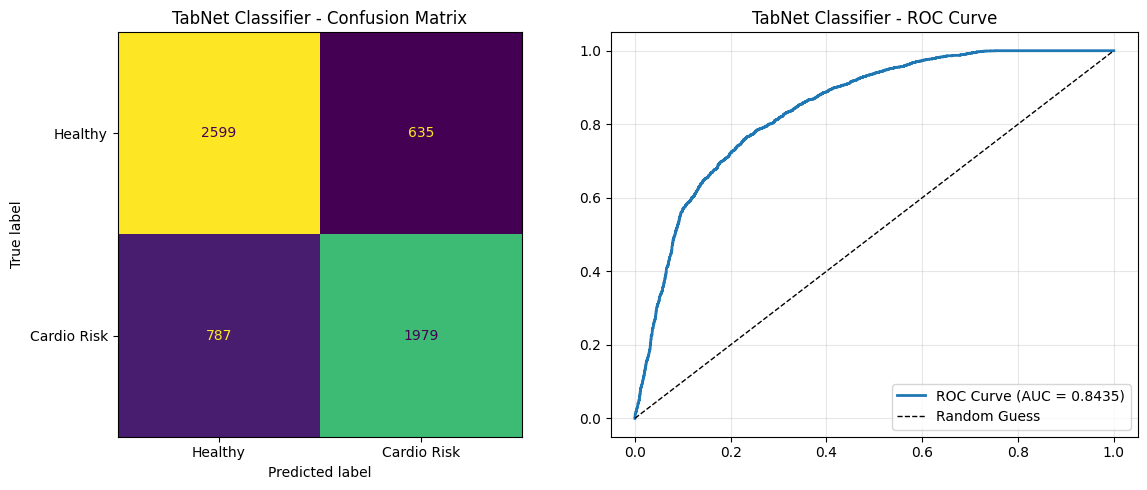

In [26]:
tabnet_model = TabNetClassifier()

evaluate_model(tabnet_model, x_train_np, y_train_np, x_test_np, y_test_np, "TabNet Classifier")

#### `DANet`

In [35]:

# 3. Konfigurasi training (sesuaikan dengan kebutuhan)
train_config = {
    'dataset': 'cardio',
    'resume_dir': '',
    'logname': 'layer8'
}

fit_config = {
    'max_epochs': 500,
    'patience': 200,
    'lr': 0.008,
    'batch_size': 8192,
    'virtual_batch_size': 256  # Pastikan virtual_batch_size membagi batch_size
}

model_config = {
    'layer': 8,
    'base_outdim': 64,
    'k': 5,
    'drop_rate': 0.1
}

# 4. Menentukan device (GPU atau CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# 5. Membuat instance model DANetClassifier
clf = DANetClassifier(
    optimizer_fn=QHAdam,
    optimizer_params=dict(lr=fit_config['lr'], weight_decay=1e-5, nus=(0.8, 1.0)),
    scheduler_params=dict(gamma=0.95, step_size=20),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    layer=model_config['layer'],
    base_outdim=model_config['base_outdim'],
    k=model_config['k'],
    drop_rate=model_config['drop_rate'],
    seed=42,
    device_name=device
)

# Melatih model menggunakan data training dan validasi
clf.fit(
    X_train=x_train_np,       # Data training dalam format numpy array
    y_train=y_train_np,       # Label training (biner) sebagai numpy array
    eval_set=[(x_val_np, y_val_np)],  # Data validasi untuk evaluasi selama training
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=fit_config['max_epochs'],
    patience=fit_config['patience'],
    batch_size=fit_config['batch_size'],
    virtual_batch_size=fit_config['virtual_batch_size'],
    logname=train_config['logname'],
    resume_dir=train_config['resume_dir'],
    n_gpu=1
)

# 7. Prediksi dan evaluasi pada data validasi atau test
preds = clf.predict(x_val_np)
acc = accuracy_score(y_val_np, preds)
print("Validation Accuracy:", acc)

Using device: cpu
Device used : cpu
===> Building model ...


TypeError: super(type, obj): obj must be an instance or subtype of type